<a href="https://colab.research.google.com/github/plvckn/yolo-vgg-binary/blob/main/vgg_binary_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
foldername = 'custom-yolo'
sys.path.append(f'/content/drive/My Drive/{foldername}')
%cd /content/drive/My\ Drive/$foldername
!ls

Mounted at /content/drive
/content/drive/My Drive/custom-yolo
Balance_dataset.ipynb  lemon_binary_classification
darkflow	       vgg_binary_train.ipynb


In [ ]:
# Packages
import numpy as np
import os
import glob
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from PIL import Image
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory

### Util

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'bin_accuracy', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1])

    plt.legend()

### Load data

In [ ]:
base_dir = r'/content/drive/My Drive/custom-yolo/lemon_binary_classification/data'
train_dataset = image_dataset_from_directory(
    os.path.join(base_dir, 'train'),
    image_size=(224,224),
    batch_size=32
)

Found 8058 files belonging to 2 classes.


In [ ]:
val_dataset = image_dataset_from_directory(
    os.path.join(base_dir, 'val'),
    image_size=(224,224),
    batch_size=16
)

Found 925 files belonging to 2 classes.


### Define model architecture

In [ ]:
base_model = VGG16(include_top=False, input_shape=(224,224,3), pooling='avg')

In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

In [ ]:
inputs = tf.keras.Input(shape=(224,224,3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem_1 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_1 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_____________________________________________

### Define training hyperparameters

In [ ]:
base_lr = 5e-4
initial_epochs = 10
metrics = [
      tf.keras.metrics.BinaryAccuracy(name='bin_accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

In [ ]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(base_lr),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics=metrics
)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    'val_loss',
    verbose=1,
    patience=5,
    restore_best_weights=True
)

### Train the model (base layers frozen)

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=val_dataset,
    callbacks=[early_stopping],
    verbose=True
)

Epoch 1/10
252/252 [==============================] - 1177s 5s/step - loss: 1.2428 - bin_accuracy: 0.7148 - precision: 0.7109 - recall: 0.7240 - val_loss: 0.7721 - val_bin_accuracy: 0.7838 - val_precision: 0.9650 - val_recall: 0.7900
Epoch 2/10
252/252 [==============================] - 77s 301ms/step - loss: 0.5800 - bin_accuracy: 0.8379 - precision: 0.8364 - recall: 0.8402 - val_loss: 0.6400 - val_bin_accuracy: 0.8141 - val_precision: 0.9784 - val_recall: 0.8126
Epoch 3/10
252/252 [==============================] - 76s 299ms/step - loss: 0.4219 - bin_accuracy: 0.8727 - precision: 0.8723 - recall: 0.8732 - val_loss: 0.5248 - val_bin_accuracy: 0.8335 - val_precision: 0.9831 - val_recall: 0.8305
Epoch 4/10
252/252 [==============================] - 76s 300ms/step - loss: 0.3331 - bin_accuracy: 0.8920 - precision: 0.8942 - recall: 0.8893 - val_loss: 0.4180 - val_bin_accuracy: 0.8616 - val_precision: 0.9823 - val_recall: 0.8628
Epoch 5/10
252/252 [==============================] - 76s 299

### Save model

In [ ]:
path = '/content/drive/My Drive/custom-yolo/lemon_binary_classification'
model.save(
    os.path.join(path, 'vgg16_binary_base')
)

INFO:tensorflow:Assets written to: /content/drive/My Drive/custom-yolo/lemon_binary_classification/vgg16_binary_converged/assets


### Finetune (unfreeze n top conv-layer blocks)

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
path = '/content/drive/My Drive/custom-yolo/lemon_binary_classification'
model = load_model(
    os.path.join(path, 'vgg16_binary_base'), compile=False
)

In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_3 True
tf.__operators__.getitem_1 True
tf.nn.bias_add_1 True
vgg16 False
dropout_1 True
dense_1 True


In [ ]:
vgg_layers = model.get_layer('vgg16')

In [ ]:
for layer in vgg_layers.layers:
  print(layer.name, layer.trainable)

input_1 True
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False
global_average_pooling2d False


In [ ]:
vgg_layers.get_layer('block4_conv1').trainable = True
vgg_layers.get_layer('block4_conv2').trainable = True
vgg_layers.get_layer('block4_conv3').trainable = True

vgg_layers.get_layer('block5_conv1').trainable = True
vgg_layers.get_layer('block5_conv2').trainable = True
vgg_layers.get_layer('block5_conv3').trainable = True

In [ ]:
for layer in vgg_layers.layers:
  print(layer.name, layer.trainable)

input_1 True
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool False
global_average_pooling2d False


In [ ]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(base_lr/20),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics=metrics
)

In [ ]:
finetune_epochs = 10
finetune_history = model.fit(
    train_dataset,
    epochs=finetune_epochs,
    validation_data=val_dataset,
    callbacks=[early_stopping],
    verbose=True,
)

Epoch 1/10
252/252 [==============================] - 1447s 5s/step - loss: 0.1800 - bin_accuracy: 0.9304 - precision: 0.9381 - recall: 0.9216 - val_loss: 0.3128 - val_bin_accuracy: 0.8811 - val_precision: 0.9802 - val_recall: 0.8866
Epoch 2/10
252/252 [==============================] - 74s 289ms/step - loss: 0.1929 - bin_accuracy: 0.9299 - precision: 0.9334 - recall: 0.9258 - val_loss: 0.3438 - val_bin_accuracy: 0.8757 - val_precision: 0.9788 - val_recall: 0.8819
Epoch 3/10
252/252 [==============================] - 74s 290ms/step - loss: 0.1857 - bin_accuracy: 0.9316 - precision: 0.9367 - recall: 0.9258 - val_loss: 0.3288 - val_bin_accuracy: 0.8703 - val_precision: 0.9761 - val_recall: 0.8783
Epoch 4/10
252/252 [==============================] - 74s 289ms/step - loss: 0.1851 - bin_accuracy: 0.9316 - precision: 0.9354 - recall: 0.9273 - val_loss: 0.3137 - val_bin_accuracy: 0.8800 - val_precision: 0.9879 - val_recall: 0.8783
Epoch 5/10
252/252 [==============================] - 74s 289

### Save model

In [ ]:
path = '/content/drive/My Drive/custom-yolo/lemon_binary_classification'
model.save(
    os.path.join(path, 'vgg16_binary_finetuned_top2_blocks')
)

INFO:tensorflow:Assets written to: /content/drive/My Drive/custom-yolo/lemon_binary_classification/vgg16_binary_finetuned_top2_blocks/assets


### Plot training progress

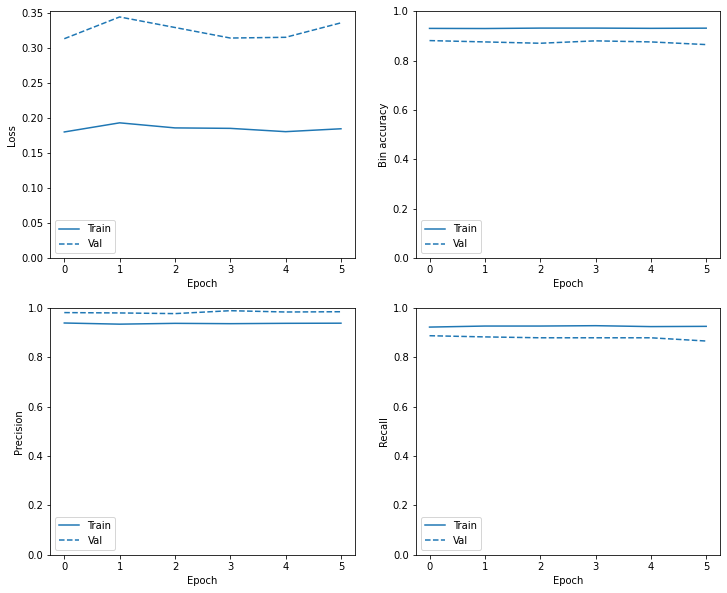

In [ ]:
plot_metrics(finetune_history)